In [1]:
from Data_Prep_Utils import *
import glob
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np

# KyFromAbove Tile Index

* The KyFromAbove 5K tile index contains three polygon feature classes for downloading the DEM, Aerial Imagery, and LiDAR point cloud datasets. Each feature class has attributes including the available datasets for each tile (some tiles have had lidar and/or imagery collected over multiple years) and data download links.

    * Note: The KyFromAbove aerial imagery is three bands (RGB), and the fourth infrared band dataset must be downloaded from the REST API without the tile index.

* The code below...
    1. The tile index is downloaded and each of the three feature class layers are read and saved as GeoJSON files. 
    2. GeoJSON tile index files are then used to extract only the relevant tiles that cover the Warren or Hardin County areas.

In [ ]:
################################
# kentucky index tile dataset
################################

# download path for tile index geodatabase zip file
download_path = r'../data/KyFromAbove_Data_Product_Tile_Grids.gdb.zip'

# custom function to download tile index, read geodatabase, and save feature classes as geojsons
get_tile_index(download_path)

## *Warren County*

In [ ]:
##############################################
# extract tiles that intersect warren county
##############################################

# list of tile index geojson file paths
index_paths = glob.glob(r'../data/*.geojson')

# # shapefile path for warren county dataset
# shapefile_path = r'../data/warren/geo_warren.shp'

# path to geodatabase
gdb_path = r'../data/geology.gdb'

# layer name of boundary feature class in geodatabase used to clip dem 
boundary_layer = r'warren_geo_boundary'

# iterate through each index (should be dem, aerial, and point cloud)
for path in index_paths:

    # get filename of index
    filename = os.path.basename(path) 
    
    # create output path
    output_path = f"../data/warren/warren_{filename}"

    # call custom function to get only intersecting tiles and save as output geojson
    get_intersecting_index_tiles(path, gdb_path, boundary_layer, output_path)

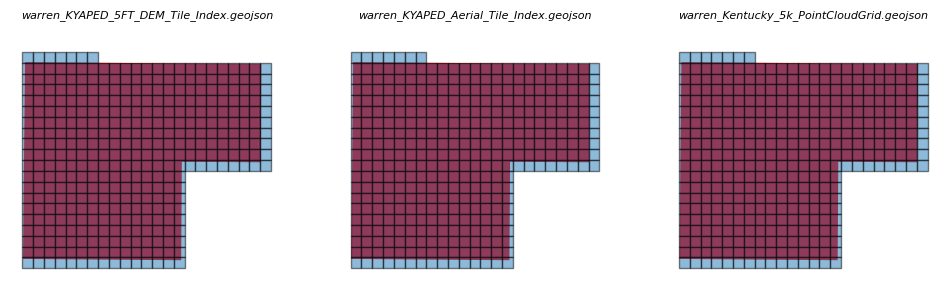

In [2]:
###############################################
# visualize coverage of index tiles and datasets
###############################################

# path to geodatabase
gdb_path = r'../data/geology.gdb'

# layer name of boundary feature class in geodatabase used to clip dem 
boundary_layer = r'warren_geo_boundary'

# get list of index geojsons for warren county
index_paths = glob.glob(r'../data/warren/*.geojson')

# read shapefile as geodataframe
gdf = gpd.read_file(gdb_path, layer=boundary_layer)

# create subplots
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

# iterate through list of geojson index paths
for idx, path in enumerate(index_paths):

    # read index geojson as geodataframe
    gdf_index = gpd.read_file(path)

    # plot...
    gdf.plot(ax=ax[idx], color='red')
    gdf_index.plot(ax=ax[idx], edgecolor='k', alpha=0.5)
    ax[idx].set_title(os.path.basename(path), style='italic', fontsize=8)
    ax[idx].set_axis_off()
    
plt.show()

## *Hardin County*

# DEM

* The Kentucky statewide digital elevation model (DEM) is derived from airborne lidar collected since 2010. The data collection prograrm has been divided into phases based on time and resolution, with Phase 1 resulting in a 5 foot resolution DEM, and a 2 foot resolution DEM for Phase 2. The data are publicly available as downloads of small tiles in either .img (with associated metadata files) or .tif (GeoTIFF).

* The code below...
    1. The tile index grids are used to download the relevant individual .tif files for the 5 foot DEM (Phase 1) in the Warren and Hardin County datasets.
    2. Individual DEM tiles are then mosaiced into a single DEM for each area and saved as a new GeoTIFF.
    3. The single DEMs for each area are finally clipped to the project area extents of Warren and Hardin Counties. 

## *Warren County*

In [ ]:
###############################################
# download DEM tiles (.tif) for Warren County
###############################################

# path to geojson dem tile index
index_path = r'../data/warren/warren_KYAPED_5FT_DEM_Tile_Index.geojson'

# field containing unique tile id for file naming
id_field = 'TileName'

# field containing geotiff download url
url_field = 'Phase1_AWS_url'

# output directory to save downloaded tiles
output_dir = r'../data/warren/dem_tiles'

# call custom function to download tiles
download_data_tiles(index_path, id_field, url_field, output_dir)

In [2]:
#############################################
# Mosaic DEM tiles into single DEM GeoTIFF
#############################################

# path to geodatabase
gdb_path = r'../data/geology.gdb'

# layer name of boundary feature class in geodatabase used to clip dem 
boundary_layer = r'warren_geo_boundary'

# path to geojson containing tile polygons
geojson_path = r'../data/warren/warren_KYAPED_5FT_DEM_Tile_Index.geojson'

# directory containing dem tiles
dem_tile_dir = r'../data/warren/dem_tiles'

# path for output dem
output_dem_path = r'../data/warren/dem.tif'


# get lists of paths of edge tiles & contained tiles
within_tile_paths, edge_tile_paths = get_contained_and_edge_tile_paths(gdb_path, boundary_layer, geojson_path, dem_tile_dir)

# iterate through edge tiles and clip to dataset boundary
for tile_path in edge_tile_paths:
    clip_image_to_boundary(tile_path, gdb_path, boundary_layer, output_tif_path=None)

# get list of clipped edge tile paths & combine with contained tile paths
clipped_edge_tile_paths = glob.glob(f"{dem_tile_dir}/*clip.tif")
tile_paths_list = within_tile_paths + clipped_edge_tile_paths

# mosaic clipped edge and contained tiles into single dem and save
mosaic_image_tiles(tile_paths_list, output_dem_path)

# clean up clipped tiles (keep original full tiles)
for path in clipped_edge_tile_paths:
    os.remove(path)

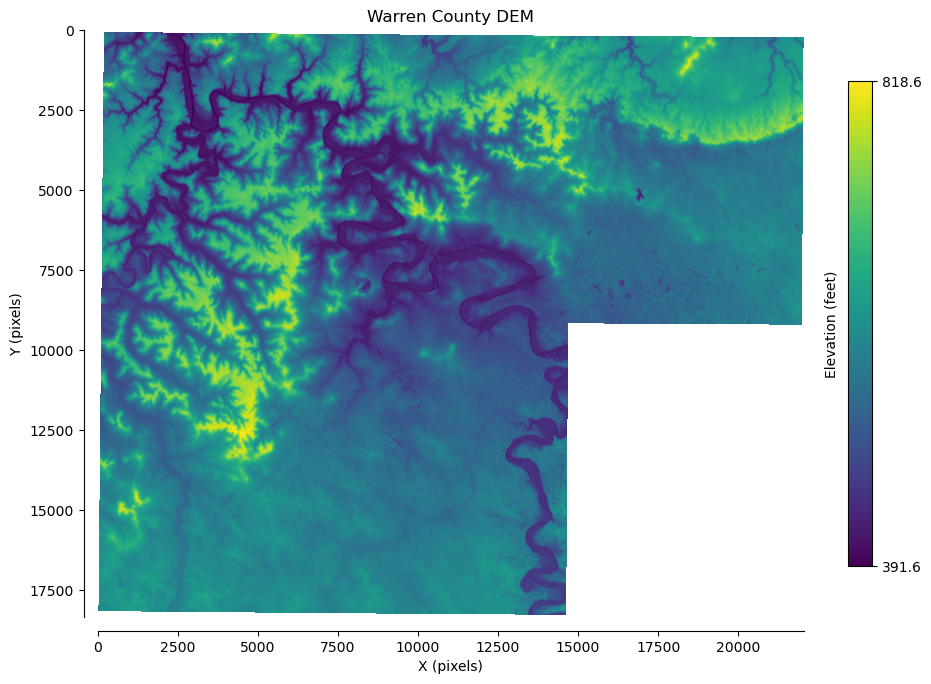

In [2]:
##########################
# visualize clipped dem
##########################

dem_path = r'../data/warren/dem.tif'

fig, ax = plt.subplots(figsize=(10,10))

with rasterio.open(dem_path) as src:
    data = src.read(1, masked=True)
    min_val = np.min(data)
    max_val = np.max(data)
    dem = ax.imshow(data, cmap='viridis', interpolation='bicubic')
    src.close()

cbar = fig.colorbar(dem, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_ticks([min_val, max_val])
cbar.set_label('Elevation (feet)', labelpad=-70)

ax.set_title('Warren County DEM')
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 10))  # Offset bottom axis
ax.spines['left'].set_position(('outward', 10))    # Offset left axis
    
plt.tight_layout()
plt.show()

## *Hardin County*

# Aerial Imagery

* Aerial imagery has been collected simultaneously with lidar through the KyFromAbove program with resolutions between 1 foot to 3 inches, and complete statewide coverage of 6 inches. Imagery was collected for true color imagery with three bands (RGB), but near infrared has been captured as a fourth band in some areas; however, only true color imagery is available for download.

* The code below...
    1. The tile index grids are used to download individual aerial imagery tiles.
    2. Individual tiles are mosaiced together and then saved as a single GeoTIFF image.
    3. The single aerial imagery files are then clipped to the boundaries of the Warren and Hardin Counties datasets.

## *Warren County*

In [2]:
#########################################################
# download aerial imagery tiles (.img) for Warren County
#########################################################

# path to geojson aerial imagery tile index
index_path = r'../data/warren/warren_KYAPED_Aerial_Tile_Index.geojson'

# field containing unique tile id for file naming
id_field = 'TileName'

# field containing geotiff download url (only available column for image downloads, 6 inch resolution)
url_field = 'Boxzip2021'

# output directory to save downloaded tiles
output_dir = r'../data/warren/aerial_tiles'

# call custom function to download tiles
download_data_tiles(index_path, id_field, url_field, output_dir)

In [2]:
#############################################
# Mosaic DEM tiles into single DEM GeoTIFF
#############################################

# path to geodatabase
gdb_path = r'../data/geology.gdb'

# layer name of boundary feature class in geodatabase used to clip dem 
boundary_layer = r'warren_geo_boundary'

# path to geojson containing tile polygons
geojson_path = r'../data/warren/warren_KYAPED_Aerial_Tile_Index.geojson'

# directory containing dem tiles
aerial_tile_dir = r'../data/warren/aerial_tiles'

# path for output dem
output_aerial_path = r'../data/warren/aerial.tif'


# get lists of paths of edge tiles & contained tiles
within_tile_paths, edge_tile_paths = get_contained_and_edge_tile_paths(gdb_path, boundary_layer, geojson_path, aerial_tile_dir)
print('got paths')

# iterate through edge tiles and clip to dataset boundary
for tile_path in edge_tile_paths:
    clip_image_to_boundary(tile_path, gdb_path, boundary_layer, output_tif_path=None)
print('clipped tiles')

# get list of clipped edge tile paths & combine with contained tile paths
clipped_edge_tile_paths = glob.glob(f"{aerial_tile_dir}/*clip.tif")
tile_paths_list = within_tile_paths + clipped_edge_tile_paths

# mosaic clipped edge and contained tiles into single dem and save
mosaic_image_tiles(tile_paths_list, output_aerial_path)

# clean up clipped tiles (keep original full tiles)
for path in clipped_edge_tile_paths:
    os.remove(path)

got paths
clipped tiles
mosaiced tiles


: 

In [2]:
output_aerial_path = r'../data/warren/aerial.tif'

fig, ax = plt.subplots()
with rasterio.open(output_aerial_path, tiled=True, blockxsize=1024, blockysize=1024) as src:
    show(src, ax=ax)

: 

In [3]:
import rasterio
help(rasterio.open)

Help on function open in module rasterio:

open(fp, mode='r', driver=None, width=None, height=None, count=None, crs=None, transform=None, dtype=None, nodata=None, sharing=False, **kwargs)
    Open a dataset for reading or writing.

    The dataset may be located in a local file, in a resource located by
    a URL, or contained within a stream of bytes.

    In read ('r') or read/write ('r+') mode, no keyword arguments are
    required: these attributes are supplied by the opened dataset.

    In write ('w' or 'w+') mode, the driver, width, height, count, and dtype
    keywords are strictly required.

    Parameters
    ----------
    fp : str, file object, PathLike object, FilePath, or MemoryFile
        A filename or URL, a file object opened in binary ('rb') mode, a
        Path object, or one of the rasterio classes that provides the
        dataset-opening interface (has an open method that returns a
        dataset).
    mode : str, optional
        'r' (read, the default), 'r+' (

In [8]:
# import glob
# import os
# aerial_tile_dir = r'../data/warren/aerial_tiles'

clipped_edge_tile_paths = glob.glob(f"{aerial_tile_dir}/*clip.tif")
clipped_edge_tile_paths
for path in clipped_edge_tile_paths:
    os.remove(path)

In [3]:
##################################################
# merge aerial imagery tiles into single geotiff
##################################################

# directory containing aerial imagery tiles
aerial_dir = r'../data/warren/aerial_tiles'

# output path for single mosaiced aerial image
output_aerial_path = r'../data/warren/aerial_mosaic.tif'

# custom function to mosaic aerial image tiles and save as new single image
mosaic_image_tiles(aerial_dir, output_aerial_path)

In [2]:
#########################################
# clip dem to warren county area extent
#########################################

# path to input mosaiced dem from above
input_im_path = r'../data/warren/aerial_mosaic.tif'

# path to geodatabase
gdb_path = r'../data/geology.gdb'

# layer name of boundary feature class in geodatabase used to clip dem 
boundary_layer = r'warren_geo_boundary'

# output path of new clipped dem
output_im_path = r'../data/warren/aerial.tif'

# call custom function to clip mosaiced dem to outline of labeled dataset boundary
clip_image_to_boundary(input_im_path, gdb_path, boundary_layer, output_im_path)

: 

In [ ]:
##########################
# visualize clipped dem
##########################

fig, ax = plt.subplots(figsize=(10,10))

with rasterio.open(output_dem_path) as src:
    data = src.read(1, masked=True)
    ax.imshow(data, cmap='viridis', interpolation='nearest')
    ax.set_title('Warren County DEM')
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 10))  # Offset bottom axis
    ax.spines['left'].set_position(('outward', 10))    # Offset left axis
    # fig.colorbar(dem, ax=ax, orientation='vertical')
    plt.tight_layout()
    plt.show()